### List of dependencies
- networkx
- pandas
- numpy
- matplotlib
- community : you can download it [here](https://bitbucket.org/taynaud/python-louvain/get/6a3696fdce57.zip), then just do  : `sudo python3 setup.py install`
 

In [1]:
import pandas as pd
import numpy as np
import community

#import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import random
import community
%matplotlib inline

In [2]:
df = pd.read_csv("../data/dataset.CSV", sep=";")

In [3]:
df.describe()

,female_id,male_id,date,female_grade,anal,oral,kiss
count,50632.000000,50632.000000,50632.000000,50632.000000,50632.000000,50632.000000,50632.000000
mean,6674.964074,6497.960045,1561.542878,0.742692,0.300758,0.665192,0.629957
std,4599.308794,4544.051880,444.996668,0.604601,0.817198,0.696622,0.696743
min,0.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2813.000000,2422.250000,1238.000000,1.000000,0.000000,1.000000,1.000000
50%,6235.000000,5766.000000,1617.000000,1.000000,1.000000,1.000000,1.000000
75%,10496.000000,10111.250000,1933.000000,1.000000,1.000000,1.000000,1.000000
max,16728.000000,16729.000000,2232.000000,1.000000,1.000000,1.000000,1.000000


### We add an offset to male id in order to not have the same ids in male and female 

In [4]:
offset_male_id = max(df["female_id"]) + 10000
df["male_id"] = df["male_id"] + offset_male_id

### Let's create the graph, we are going to use Multi Graph because we may have multiple edges between the same escort and client

In [5]:
G = nx.MultiGraph()

In [6]:
list_male_id = df["male_id"].unique()
list_female_id = df["female_id"].unique()


### Be sure that there is no intersection between ids

In [7]:
len(set(list_male_id).intersection(set(list_female_id)))

0

In [8]:
print(len(list_male_id), " different clients")

10106  different clients


In [9]:
print(len(list_female_id), " different escort")

6624  different escort


In [10]:
full_node_list = list(list_female_id) + list(list_male_id)

In [11]:
G.add_nodes_from(list_male_id, role="client",status="clean")
G.add_nodes_from(list_female_id, role="escort",status="clean")

### We simulate a basic model of infection

In [12]:
proba_transmission = 0.8
coeff_initial_infected = 0.01
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)


value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

In [21]:
def print_stat_inf(G, display=False):
    number_of_nodes = G.number_of_nodes()
    number_infected = 0
    
    for node, data in G.nodes_iter(data=True):
        if data["status"] == "infected":
            number_infected += 1
    if display==True:
        print("Number of infected : ",number_infected)
        print(number_infected/number_of_nodes * 100," % of the population infected")
    return number_infected

In [22]:
number_infected = print_stat_inf(G, display=True)

Number of infected :  12280
73.40107591153617  % of the population infected


In [15]:
%%time

date_list = []
infected_list = []

for index, row in df.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="clean"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="clean"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])
    


Added  0  edges
Added  3000  edges
Added  6000  edges
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Added  42000  edges
Added  45000  edges
Added  48000  edges
CPU times: user 2min 37s, sys: 124 ms, total: 2min 37s
Wall time: 2min 37s


In [16]:
df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list

In [23]:
groupby_date = df_infection.groupby("date").max()

In [24]:
groupby_date

,nb_infecte
date,
0,167
21,167
47,167
73,167
105,167
121,167
124,167
126,167
168,167


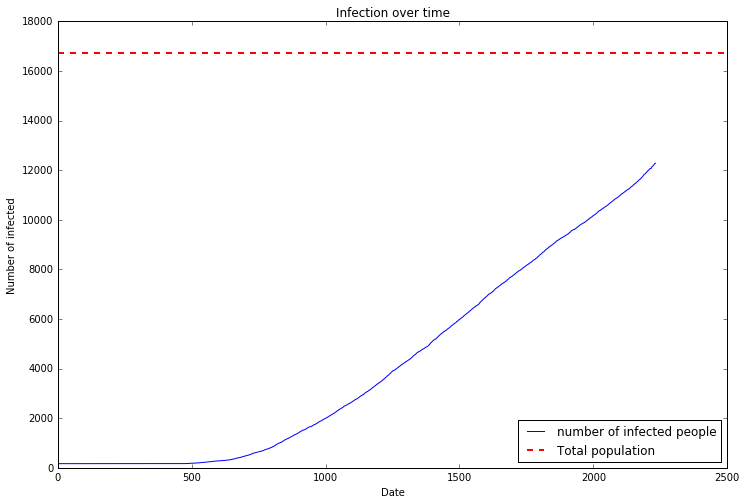

In [30]:
plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date.index, groupby_date["nb_infecte"], label="number of infected people")
plt.ylabel("Number of infected")
plt.xlabel("Date")
plt.axhline(y=G.number_of_nodes(), xmin=0, xmax=3000, linewidth=2, linestyle="dashed",color = 'r', label="Total population")
plt.legend(loc=4)